In [1]:
pip install tensorflow keras numpy opencv-python scikit-learn matplotlib


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data_dir = '/content/drive/MyDrive/GestureRecognitionDataset/leapGestRecog'


In [14]:
import os

# Check if the path exists
if os.path.exists(data_dir):
    print(f"Directory exists: {data_dir}")
    print("Subdirectories:")
    print(os.listdir(data_dir))
else:
    print(f"Directory not found: {data_dir}")


Directory exists: /content/drive/MyDrive/GestureRecognitionDataset/leapGestRecog
Subdirectories:
['09', '05', '04', '02', 'leapGestRecog', '01', '03', '07', '06', '08', '00']


In [15]:
data_dir = '/content/drive/MyDrive/GestureRecognitionDataset/leapGestRecog'


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 500ms/step - accuracy: 0.3990 - loss: 1.6363 - val_accuracy: 0.9493 - val_loss: 0.1566
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 134s 468ms/step - accuracy: 0.9064 - loss: 0.2572 - val_accuracy: 0.9890 - val_loss: 0.0298
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 466ms/step - accuracy: 0.9554 - loss: 0.1171 - val_accuracy: 0.9900 - val_loss: 0.0214
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.9661 - loss: 0.0873 - val_accuracy: 0.9910 - val_loss: 0.0165
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 144s 475ms/step - accuracy: 0.9726 - loss: 0.0720 - val_accuracy: 0.9838 - val_loss: 0.0367
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 145s 486ms/step - accuracy: 0.9716 - loss: 0.0660 - val_accuracy: 0.9908 - val_loss: 0.0148
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 465ms/step - accuracy: 0.9814 - loss: 0.0448 - val_accuracy: 0.9910 - val_loss: 0.0141
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 117s 466ms/step - accuracy: 0.9828 -

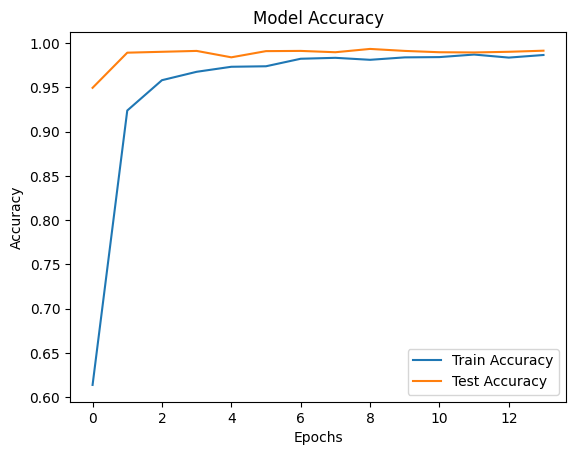

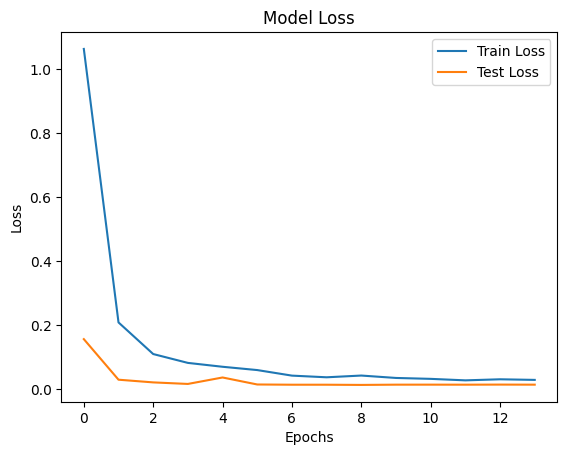

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set the directory path
data_dir = '/content/drive/MyDrive/GestureRecognitionDataset/leapGestRecog'
gestures = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
image_size = 64

def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            images.append((img, label))
    return images

def load_dataset(data_dir):
    images = []
    for idx, gesture in enumerate(gestures):
        folder_path = os.path.join(data_dir, f'{str(idx).zfill(2)}')

        if not os.path.exists(folder_path):
            print(f"Folder {folder_path} does not exist. Skipping.")
            continue

        subfolders = os.listdir(folder_path)

        if not subfolders:
            print(f"No subfolders found in {folder_path}. Skipping.")
            continue

        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                images += load_images_from_folder(subfolder_path, idx)
            else:
                print(f"{subfolder_path} is not a directory. Skipping.")

    return images

# Load and preprocess data
dataset = load_dataset(data_dir)
if not dataset:
    raise ValueError("Dataset could not be loaded. Please check the directory paths.")

X, y = zip(*dataset)
X = np.array(X).reshape(-1, image_size, image_size, 1) / 255.0
y = np.array(y)

# Encode labels to one-hot vectors
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('/content/drive/MyDrive/your-folder/gesture_recognition_model.h5' )
